In [29]:
import numpy as np
import pandas as pd
import time
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier
from itertools import chain, combinations
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

data = np.load('data.npy', allow_pickle=True)
print(data.shape)

(1500, 5)


In [31]:
print(1500**0.5)

38.72983346207417


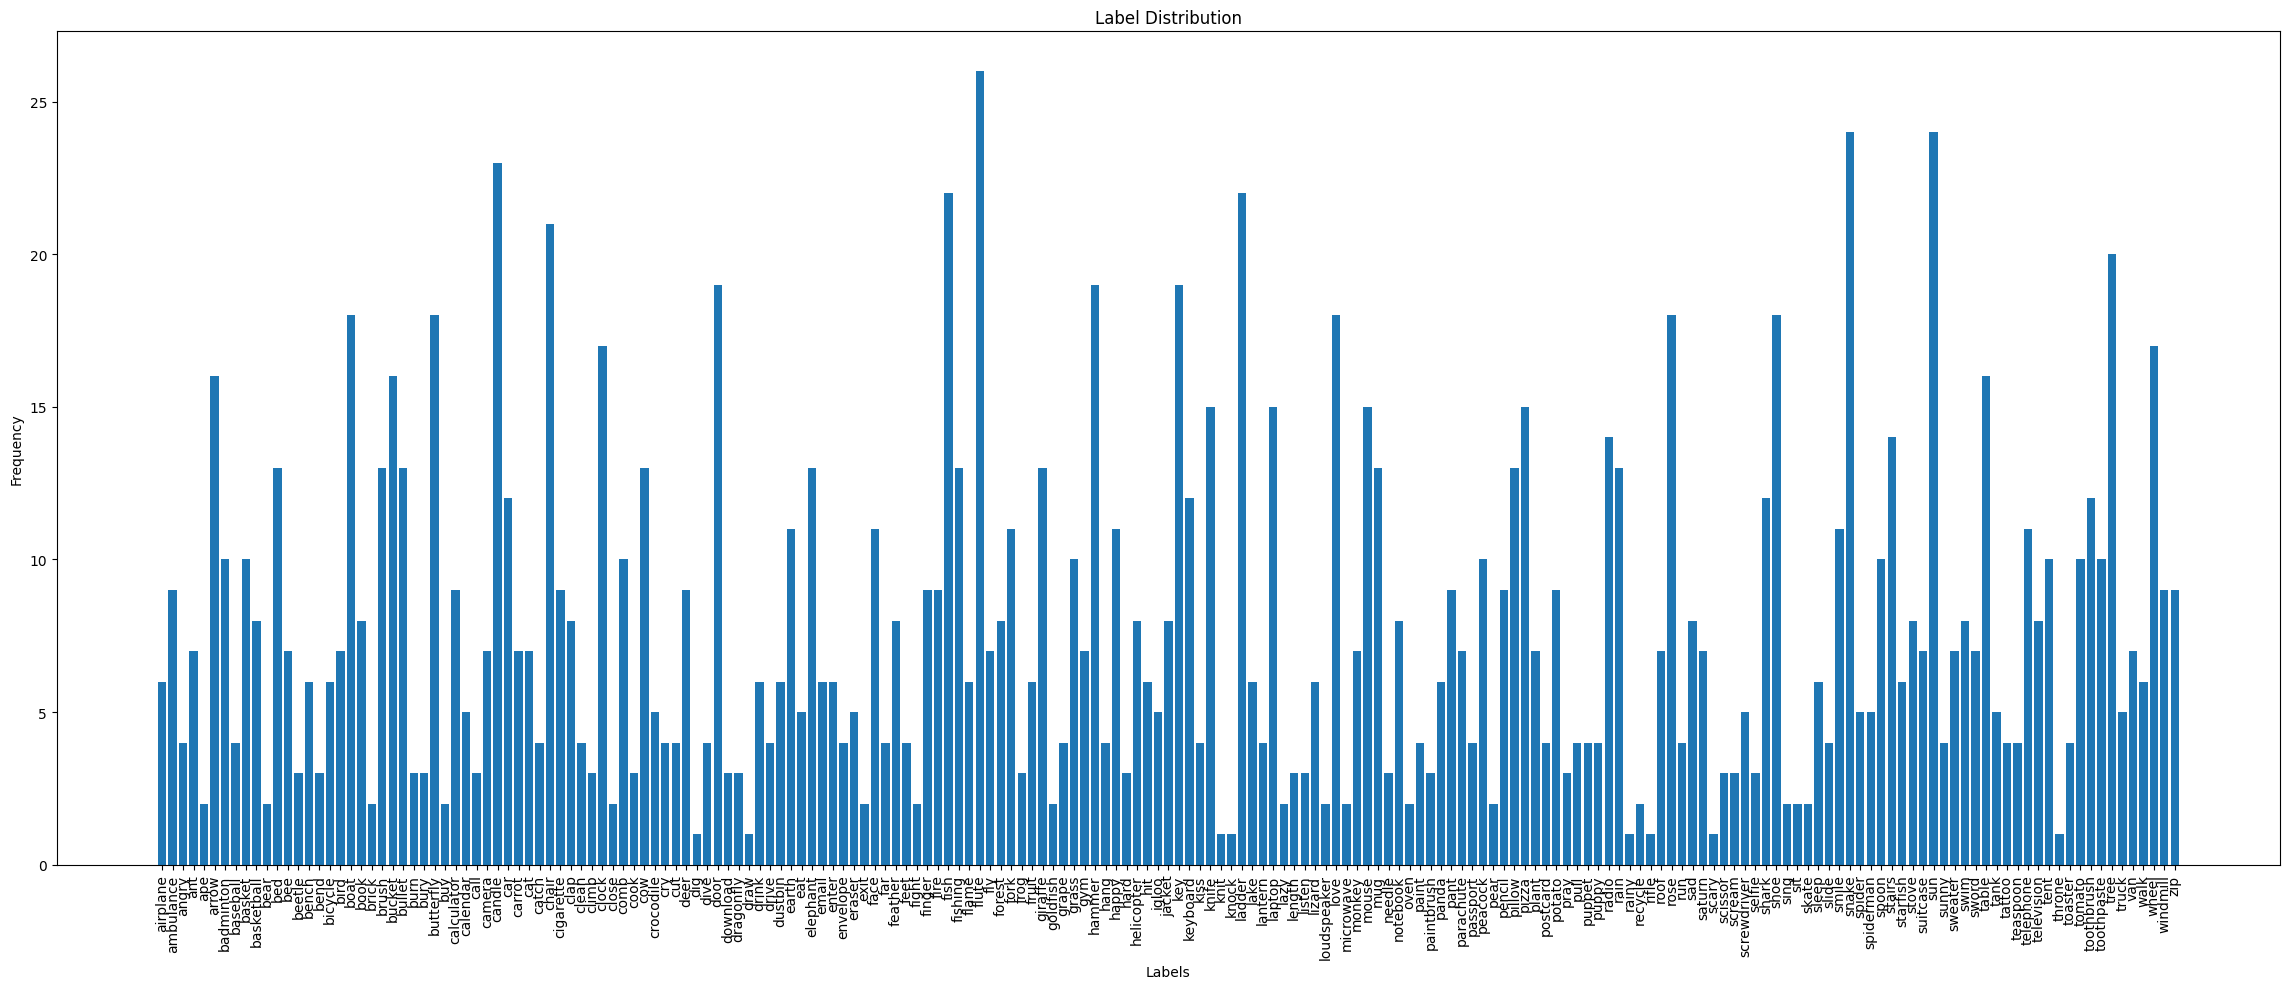

In [16]:
# 2.2.1
labels = data[:, 3]

# Calculate label frequencies
unique_arr, count_arr = np.unique(labels, return_counts=True)

# Create a bar plot to show label distribution
plt.figure(figsize=(23,10))
plt.bar(unique_arr, count_arr)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Label Distribution')
plt.xticks(rotation=90)  # Show all unique labels on x-axis

plt.tight_layout()  # Adjust layout for better readability
plt.show()

In [17]:
# 2.3.1 Task 1 [30]
class KNNInitial:
    def __init__(self,k,distance_metric):
        self.k = k
        self.distance_metric = distance_metric
        self.encoder_type = None
        self.x_train = None
        self.y_train = None
    
    def fit_model(self,x_train,y_train,encoder_type):
        self.x_train = x_train
        self.y_train = y_train
        self.encoder_type = encoder_type
    
    
    def euclidean_dist(self,x1, x2):
        # sqrt(sum((x1[i] - x2[i])^2))
        return np.sqrt(np.sum((x1 - x2)**2))
    
    def manhattan_dist(self,x1, x2):
        # sum of absolute difference of x1[i],x2[i]
        return np.sum(np.abs(x1 - x2))

    def cosine_dist(self,x1, x2):
        # A.B = |A|.|B|.Cos(Theta)
        # Cos(Theta) = A.B/(|A|.|B|)
        dot_product = np.dot(x1[0], x2[0])
        norm_x1 = np.linalg.norm(x1)
        norm_x2 = np.linalg.norm(x2)
        return (1 - (dot_product / (norm_x1 * norm_x2)))
    
    def calc_dist(self,x1,x2):
        if(self.distance_metric == "euclidean"):
            return self.euclidean_dist(x1,x2)
        
        if(self.distance_metric == "manhattan"):
            return self.manhattan_dist(x1,x2)
        
        if(self.distance_metric == "cosine"):
            return self.cosine_dist(x1,x2)
        
        return None #invalid distance_metric

    def pred(self,x):
        dist = []
        for entry in self.x_train:
            dist.append(self.calc_dist(x,entry))
        
        k_indices = np.argsort(dist)[:self.k]
        k_list = []
        for i in k_indices:
            k_list.append(self.y_train[i])
        
        label_pred = Counter(k_list).most_common(1)[0][0]
        
        return label_pred
    
    def eval(self,x_test,y_test):
        y_pred = []
        for entry in x_test:
            y_pred.append(self.pred(entry))
        
        f1 = f1_score(y_test, y_pred, average='macro',zero_division=0)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro',zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro',zero_division=0)
        return f1, accuracy, precision, recall

In [18]:
# 2.4 Hyperparameter Tuning
class KNNOptimised:
    def __init__(self, k, distance_metric):
        self.k = k
        self.distance_metric = distance_metric
        self.encoder_type = None
        self.x_train = None
        self.y_train = None
    
    def fit_model(self,x_train,y_train,encoder_type):
        self.x_train = x_train
        self.y_train = y_train
        self.encoder_type = encoder_type
    
    def euclidean_dist(self,x):
        return np.linalg.norm(self.x_train - x, axis=1)
    
    def manhattan_dist(self,x):
        return np.linalg.norm(self.x_train - x, ord=1, axis=1)
    
    def cosine_dist(self,x):
        # A.B = |A|.|B|.Cos(Theta)
        # Cos(Theta) = A.B/(|A|.|B|)
        dot_product = np.dot(self.x_train, x)
        norm_x1 = np.linalg.norm(self.x_train,axis=1)
        norm_x2 = np.linalg.norm(x)
        return 1 - (dot_product / (norm_x1 * norm_x2))
    
    def calc_dist(self,x):
        if(self.distance_metric == "euclidean"):
            return self.euclidean_dist(x)
        
        if(self.distance_metric == "manhattan"):
            return self.manhattan_dist(x)
        
        if(self.distance_metric == "cosine"):
            return self.cosine_dist(x)
        
        return None #invalid distance_metric

    def pred(self,x):
        dist = self.calc_dist(x)
        k_indices = np.argsort(dist)[:self.k]
        k_list = self.y_train[k_indices]    # list of labels with index from k_indices
        label_pred = Counter(k_list).most_common(1)[0][0]
        
        return label_pred
    
    def eval(self,x_test,y_test):
        y_pred = [self.pred(entry) for entry in x_test]
        f1 = f1_score(y_test, y_pred, average='macro',zero_division=0)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro',zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro',zero_division=0)
        return f1, accuracy, precision, recall

In [19]:
# 2.4.1 Task 2 [30]
encoder_list = ["resnet", "VIT"]
dist_list = ["euclidean", "manhattan", "cosine"]

model_list = []
max_accuracy = 0.0
optknn_infer_time = np.inf
bestknn_infer_time = np.inf
best_knn = None
opt_knn = None

for k in range(1,21):       # k ranges from 1 to (sqrt of total data points)
    for encoder_type in encoder_list:
        for dist_metric in dist_list:
            encoder_col = 1 if encoder_type == "resnet" else 2
            embeddings = data[:, encoder_col]
            embeddings = [arr.flatten() for arr in embeddings]
            embeddings = np.array(embeddings)
            x_train, x_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=21)
            
            start_time = time.time()
            knn = KNNOptimised(k, dist_metric)
            knn.fit_model(x_train, y_train, encoder_type)
            f1, accuracy_val, precision, recall = knn.eval(x_test, y_test)
            end_time = time.time()
            
            model_list.append({"k": k, "encoder": encoder_type, "distance_metric":dist_metric,"accuracy":accuracy_val})

            temp_time = end_time - start_time
            if(accuracy_val > max_accuracy):
                best_knn = [k,encoder_type,dist_metric] 
                bestknn_infer_time = temp_time
            
            if(temp_time < optknn_infer_time):
                opt_knn = [k,encoder_type,dist_metric] 
                optknn_infer_time = temp_time
            
model_list = sorted(model_list, key=lambda x: x["accuracy"], reverse=True)

print("Best (k, encoder, distance metric) triplet: ("+str(model_list[0]["k"])+","+str(model_list[0]["encoder"])+","+str(model_list[0]["distance_metric"])+")")

for i in range(0,20):
    print("("+str(model_list[i]["k"])+","+str(model_list[i]["encoder"])+","+str(model_list[i]["distance_metric"])+") - accuracy: "+str(model_list[i]["accuracy"]))


Best (k, encoder, distance metric) triplet: (7,VIT,manhattan)
(7,VIT,manhattan) - accuracy: 0.3
(8,VIT,manhattan) - accuracy: 0.3
(11,VIT,manhattan) - accuracy: 0.3
(12,VIT,manhattan) - accuracy: 0.3
(9,VIT,manhattan) - accuracy: 0.2966666666666667
(10,VIT,manhattan) - accuracy: 0.2966666666666667
(6,VIT,manhattan) - accuracy: 0.29333333333333333
(5,VIT,euclidean) - accuracy: 0.29
(6,VIT,euclidean) - accuracy: 0.29
(7,VIT,euclidean) - accuracy: 0.29
(9,VIT,cosine) - accuracy: 0.29
(5,VIT,manhattan) - accuracy: 0.2866666666666667
(7,VIT,cosine) - accuracy: 0.2866666666666667
(11,VIT,cosine) - accuracy: 0.2866666666666667
(5,VIT,cosine) - accuracy: 0.2833333333333333
(8,VIT,cosine) - accuracy: 0.2833333333333333
(13,VIT,manhattan) - accuracy: 0.2833333333333333
(19,VIT,manhattan) - accuracy: 0.2833333333333333
(8,VIT,euclidean) - accuracy: 0.28
(10,VIT,cosine) - accuracy: 0.28


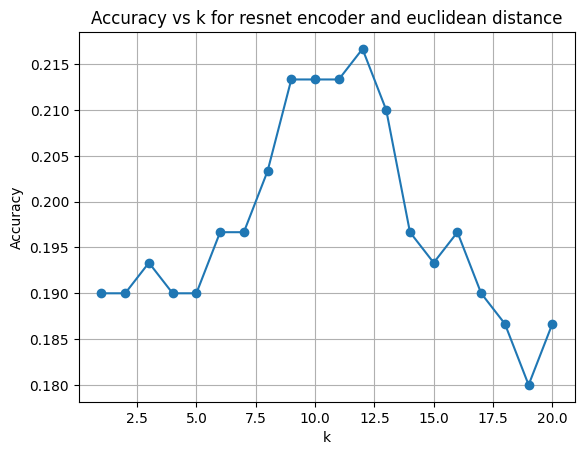

In [20]:
# Plot k vs accuracy
encoder_type = "resnet"
dist_metric = "euclidean"
k_list = []
accuracy_list = []

for k in range(1,21):       
    embeddings = data[:, 1]  
    embeddings = [arr.flatten() for arr in embeddings]
    embeddings = np.array(embeddings)
    x_train, x_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=21)
    knn = KNNOptimised(k, dist_metric)
    knn.fit_model(x_train, y_train, encoder_type)
    f1, accuracy_val, precision, recall = knn.eval(x_test, y_test)
    k_list.append(k)
    accuracy_list.append(accuracy_val)

plt.plot(k_list, accuracy_list, marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title(f'Accuracy vs k for {encoder_type} encoder and {dist_metric} distance')
plt.grid(True)
plt.show()


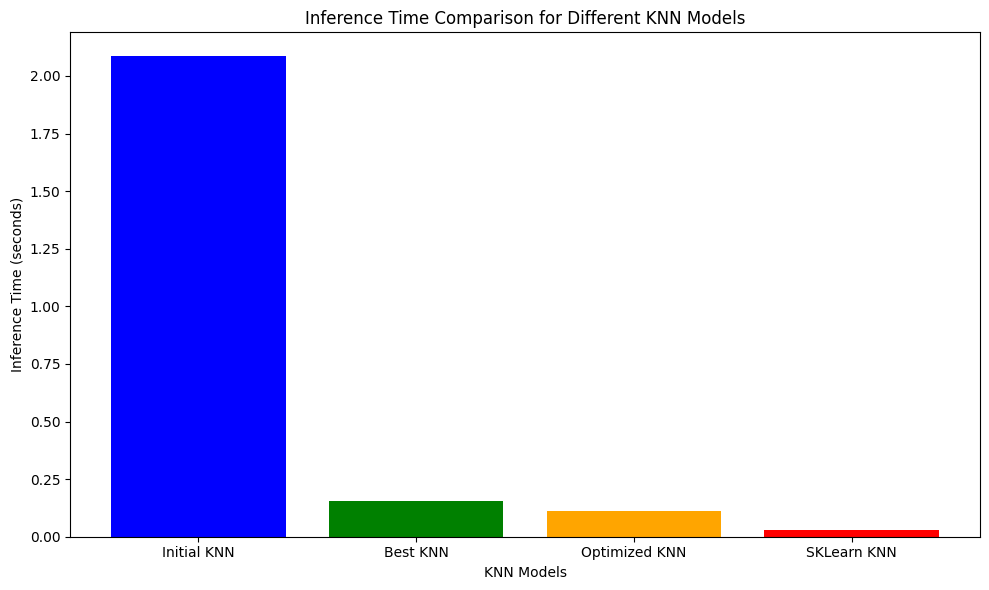

In [21]:
# plot inference_time vs knn_model
embeddings = data[:, 1]
embeddings = [arr.flatten() for arr in embeddings]
embeddings = np.array(embeddings)
x_train, x_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=21)

# Initial KNN Model
knn = KNNInitial(5, "euclidean")
knn.fit_model(x_train, y_train, "resnet")
start_time = time.time()
f1, accuracy_val, precision, recall = knn.eval(x_test, y_test)
end_time = time.time()
initialknn_infer_time = end_time - start_time
# Initial KNN Model

#default KNN Model
defaultknn_model = KNeighborsClassifier(n_neighbors=5)
defaultknn_model.fit(x_train, y_train)
start_time = time.time()
y_pred = defaultknn_model.predict(x_test)
end_time = time.time()

defaultknn_infer_time = end_time - start_time
#default KNN Model


models = ["Initial KNN", "Best KNN", "Optimized KNN", "SKLearn KNN"]
inference_times = [initialknn_infer_time, bestknn_infer_time, optknn_infer_time, defaultknn_infer_time]

plt.figure(figsize=(10, 6))
plt.bar(models, inference_times, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('KNN Models')
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time Comparison for Different KNN Models')
plt.tight_layout()
plt.show()

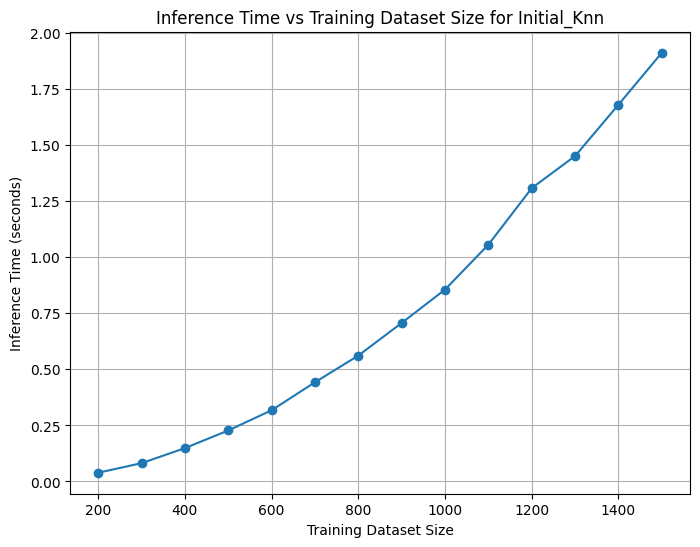

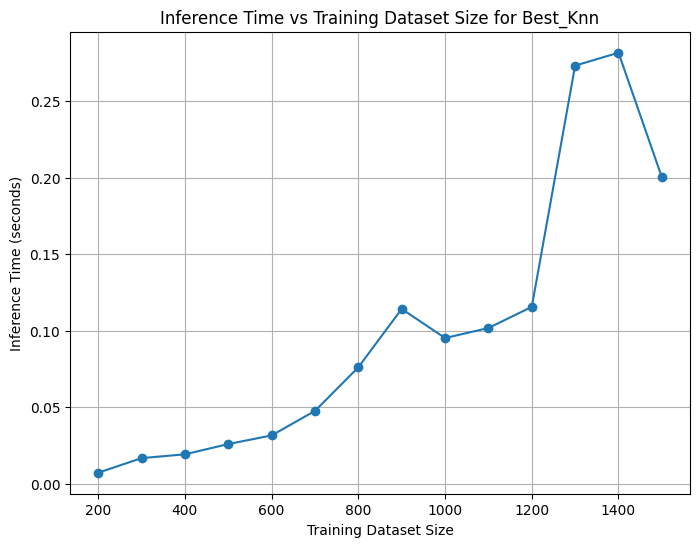

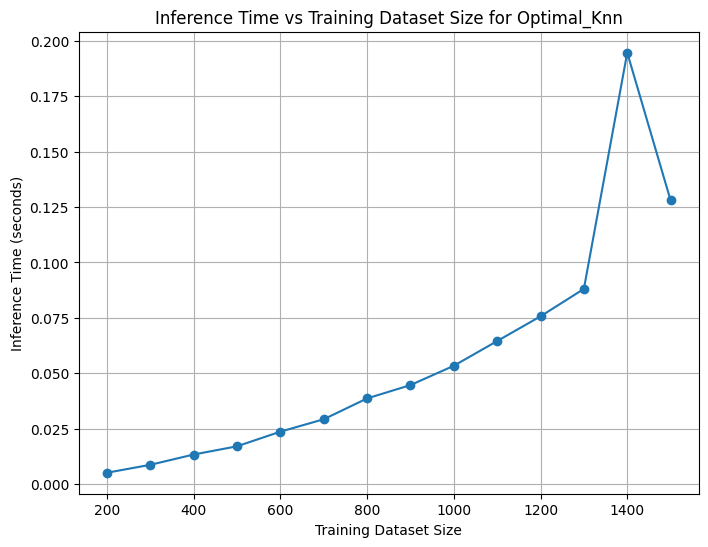

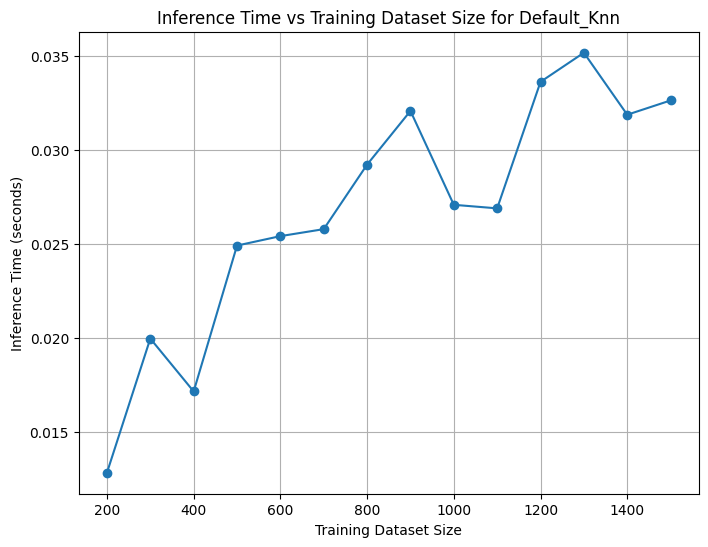

In [22]:
# plot the inference time vs train dataset size

initial_knn = [5,"resnet","euclidean"]
default_knn = [5,"resnet","euclidean"]

def get_plots(knn_model,knn_type):
    train_size = [200, 300, 400, 500, 600, 700, 800, 900, 1000,1100, 1200, 1300, 1400, 1500]
    infer_times_list = []
    k, encoder_type, dist_metric = knn_model
    for sz in train_size:
        encoder_col = 1 if encoder_type == "resnet" else 2
        embeddings = data[:, encoder_col]
        embeddings = [arr.flatten() for arr in embeddings]
        embeddings = embeddings[:sz]
        labels_sz = labels[:sz]
        embeddings = np.array(embeddings)
        x_train, x_test, y_train, y_test = train_test_split(embeddings, labels_sz, test_size=0.2, random_state=21)
        knn = None
        knn_name = ''
        if(knn_type == 0):
            knn_name = 'Initial_Knn'
            knn = KNNInitial(k,dist_metric)
            knn.fit_model(x_train, y_train, encoder_type)
            start_time = time.time()
            f1, accuracy_val, precision, recall = knn.eval(x_test, y_test)
            end_time = time.time()
        elif (knn_type == 1 or knn_type == 2):
            if(knn_type == 1):
                knn_name = 'Best_Knn'
            else:
                knn_name = 'Optimal_Knn'
            knn = KNNOptimised(k, dist_metric)
            knn.fit_model(x_train, y_train, encoder_type)
            start_time = time.time()
            f1, accuracy_val, precision, recall = knn.eval(x_test, y_test)
            end_time = time.time()
        else:
            knn_name = 'Default_Knn'
            KNeighborsClassifier(n_neighbors=5)
            defaultknn_model.fit(x_train, y_train)
            start_time = time.time()
            y_pred = defaultknn_model.predict(x_test)
            end_time = time.time()
        infer_times_list.append(end_time - start_time)
    
    plt.figure(figsize=(8, 6))
    plt.plot(train_size, infer_times_list, marker='o')
    plt.xlabel('Training Dataset Size')
    plt.ylabel('Inference Time (seconds)')
    plt.title(f'Inference Time vs Training Dataset Size for {knn_name}')
    plt.grid(True)
    plt.show()


# KNNInitial
get_plots(initial_knn,0)
get_plots(best_knn,1)
get_plots(opt_knn,2)
get_plots(default_knn,3)


In [23]:
# Decision Tree Classifier - Powerset Formulation
class DecisionTreePowerset:
    def __init__(self, max_depth=None, max_features=None, criterion='gini'):
        self.max_depth = max_depth
        self.max_features = max_features
        self.criterion = criterion
        self.label_map = None

    def get_target(self,powerset,y):
        y_bin = []
        len_powerset = np.power(2,len(self.label_map))
        for label in y:
            temp_bin = np.zeros(len_powerset)
            for i in range(0,len_powerset):
                subset = powerset[i]
                if(np.array_equal(sorted(subset), sorted(label))):
                    temp_bin[i] = 1
            y_bin.append(temp_bin)
        return np.array(y_bin)

    def get_unique_labels(self,label_list):
        label_map = {}
        for i in range(0,len(label_list)):
            label_list[i] = label_list[i].split(" ")    # split the string into list of labels
            for j in range(0,len(label_list[i])):
                if(label_list[i][j] not in label_map):
                    label_map[label_list[i][j]] = 1
                else:
                    label_map[label_list[i][j]] += 1
        return label_map
    
    def get_powerset(self,iterable):
        s = list(iterable)
        iter_tuples = chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
        return list(iter_tuples)
    
    def process_data(self):
        data_frame = pd.read_csv('advertisement.csv')
        categorical_columns = ['gender', 'education', 'married', 'city', 'occupation','most bought item']
        encoded_data = pd.get_dummies(data_frame, columns=categorical_columns)
        target = encoded_data.iloc[:, 4].values               # get 5th column in target variable
        encoded_data = encoded_data.drop(encoded_data.columns[4], axis=1)   # delete 5th column - label
        
        self.label_map = self.get_unique_labels(target)       # map to store unique labels
        powerset = self.get_powerset(self.label_map.keys())       # get powerset of unique labels
        features = encoded_data.iloc[:, :].values        # get encoded data to features as numpy array
        target_final = self.get_target(powerset,target)
        return features, target_final
    
    def pred(self,x_train, x_test, y_train, y_test):
        dt_classifier = DecisionTreeClassifier(max_depth=self.max_depth, max_features=self.max_features, criterion=self.criterion)
        dt_classifier.fit(x_train, y_train)
        y_pred = dt_classifier.predict(x_test)
        return y_test,y_pred
    
    def eval(self,y_test,y_pred):
        accuracy = accuracy_score(y_test, y_pred)
        f1_micro = f1_score(y_test, y_pred, average='micro',zero_division=0)
        f1_macro = f1_score(y_test, y_pred, average='macro',zero_division=0)

        conf_mat = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
        # conf_mat = multilabel_confusion_matrix(y_test, y_pred)

        precision = precision_score(y_test, y_pred, average='macro',zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro',zero_division=0)
        return accuracy, f1_micro, f1_macro, conf_mat, precision, recall

# 3.3.1 Tasks[50]
dt_class_powerset = DecisionTreePowerset(5, 10, 'entropy')
features, target = dt_class_powerset.process_data()
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=21)
y_test,  y_pred = dt_class_powerset.pred(x_train, x_test, y_train, y_test)
accuracy, f1_micro, f1_macro, conf_mat, precision, recall = dt_class_powerset.eval(y_test,y_pred)

print(f"MultiOutput Formulation Accuracy: {accuracy:.5f}")


MultiOutput Formulation Accuracy: 0.00000


In [24]:
# Decision Tree Classifier - MultiOutput Formulation
class DecisionTreeMultiOutput:
    def __init__(self, max_depth=None, max_features=None, criterion='gini'):
        self.max_depth = max_depth
        self.max_features = max_features
        self.criterion = criterion
        self.label_map = None

    def multi_output_label(self,y):
        y_bin = []
        for multilabel in y:
            temp_bin = np.zeros(len(self.label_map))
            for label in multilabel:
                temp_bin[list(self.label_map.keys()).index(label)] = 1
            y_bin.append(temp_bin)
        return np.array(y_bin)

    def get_unique_labels(self,label_list):
        label_map = {}
        for i in range(0,len(label_list)):
            label_list[i] = label_list[i].split(" ")    # split the string into list of labels
            for j in range(0,len(label_list[i])):
                if(label_list[i][j] not in label_map):
                    label_map[label_list[i][j]] = 1
                else:
                    label_map[label_list[i][j]] += 1
        return label_map
    
    def process_data(self):
        data_frame = pd.read_csv('advertisement.csv')
        categorical_columns = ['gender', 'education', 'married', 'city', 'occupation','most bought item']
        encoded_data = pd.get_dummies(data_frame, columns=categorical_columns)
        target = encoded_data.iloc[:, 4].values               # get 5th column in target variable
        encoded_data = encoded_data.drop(encoded_data.columns[4], axis=1)   # delete 5th column - label
        
        self.label_map = self.get_unique_labels(target)       # map to store unique labels
        features = encoded_data.iloc[:, :].values             # get encoded data to features as numpy array
        target = self.multi_output_label(target)
        return features, target
    
    def pred(self,x_train, x_test, y_train, y_test):
        dt_classifier = DecisionTreeClassifier(max_depth=self.max_depth, max_features=self.max_features, criterion=self.criterion)
        dt_classifier.fit(x_train, y_train)
        y_pred = dt_classifier.predict(x_test)
        return y_test, y_pred
    
    def eval(self,y_test,y_pred):
        accuracy = accuracy_score(y_test, y_pred)
        f1_micro = f1_score(y_test, y_pred, average='micro',zero_division=0)
        f1_macro = f1_score(y_test, y_pred, average='macro',zero_division=0)

        conf_mat = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
        # conf_mat = multilabel_confusion_matrix(y_test, y_pred)

        precision = precision_score(y_test, y_pred, average='macro',zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro',zero_division=0)
        return accuracy, f1_micro, f1_macro, conf_mat, precision, recall

# 3.3.1 Tasks[50]
dt_class_multioutput = DecisionTreeMultiOutput(5, 10, 'entropy')
features, target = dt_class_multioutput.process_data()
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=21)
y_test, y_pred = dt_class_multioutput.pred(x_train, x_test, y_train, y_test)

accuracy, f1_micro, f1_macro, conf_mat, precision, recall = dt_class_multioutput.eval(y_test,y_pred)
print(f"MultiOutput Formulation Accuracy: {accuracy:.5f}")


MultiOutput Formulation Accuracy: 0.00000


In [25]:
# 3.4 Hyperparamter Tuning
criterion_list = ['gini', 'entropy']
max_depth_list = [3,5,10,20,30]
max_features_list = [3,5,7,9,11]

model_list = []
best_powerset_model = None
best_multioutput_model = None
best_f1_score = 0.0

# PowerSet Setting - Metrics
for criterion in criterion_list:
    for max_depth in max_depth_list:
        for max_features in max_features_list:
            dt_class_powerset = DecisionTreePowerset(max_depth, max_features, criterion)
            features, target = dt_class_powerset.process_data()
            x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=21)
            y_test,  y_pred = dt_class_powerset.pred(x_train, x_test, y_train, y_test)
            accuracy, f1_micro, f1_macro, conf_mat, precision, recall = dt_class_powerset.eval(y_test,y_pred)
            if(f1_macro > best_f1_score):
                best_powerset_model = [max_depth,max_features,criterion]
                best_f1_score = f1_macro
            model_list.append({"accuracy":accuracy,"f1_micro": f1_micro,"f1_macro":f1_macro,"conf_mat":conf_mat,"precision":precision,"recall":recall})

model_list = sorted(model_list, key=lambda x: x["f1_macro"], reverse=True)  # sort by f1_macro

print("# PowerSet Setting - Metrics")
for i in range(0,min(3,len(model_list))):
    print(model_list[i])

best_f1_score = 0.0
# MultiOutput Setting - Metrics
for criterion in criterion_list:
    for max_depth in max_depth_list:
        for max_features in max_features_list:
            dt_class_multioutput = DecisionTreeMultiOutput(max_depth, max_features, criterion)
            features, target = dt_class_multioutput.process_data()
            x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=21)
            y_test,  y_pred = dt_class_multioutput.pred(x_train, x_test, y_train, y_test)
            accuracy, f1_micro, f1_macro, conf_mat, precision, recall = dt_class_multioutput.eval(y_test,y_pred)
            if(f1_macro > best_f1_score):
                best_multioutput_model = [max_depth,max_features,criterion]
                best_f1_score = f1_macro
            model_list.append({"max_depth":max_depth,"max_features":max_features,"criterion":criterion,"accuracy":accuracy,"f1_micro": f1_micro,"f1_macro":f1_macro,"conf_mat":conf_mat,"precision":precision,"recall":recall})

model_list = sorted(model_list, key=lambda x: x["f1_macro"], reverse=True)  # sort by f1_macro

print("\n\n# MultiOutput Setting - Metrics")
for i in range(0,min(3,len(model_list))):
    print(model_list[i])


# PowerSet Setting - Metrics
{'accuracy': 0.025, 'f1_micro': 0.03508771929824561, 'f1_macro': 0.0068018353174603184, 'conf_mat': array([[0, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 'precision': 0.008919270833333333, 'recall': 0.006966145833333333}
{'accuracy': 0.015, 'f1_micro': 0.022388059701492536, 'f1_macro': 0.005208333333333333, 'conf_mat': array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [3, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 'precision': 0.0078125, 'recall': 0.0056640625}
{'accuracy': 0.005, 'f1_micro': 0.00947867298578199, 'f1_macro': 0.00390625, 'conf_mat': array([[0, 0, 0, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0

In [26]:
# KFold - PreProcess
max_depth,max_features,criterion = best_powerset_model
best_powerset_model = DecisionTreePowerset(max_depth,max_features,criterion)
max_depth,max_features,criterion = best_multioutput_model
best_multioutput_model = DecisionTreeMultiOutput(max_depth,max_features,criterion)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store evaluation metrics
accuracy_list = []
precision_list = []
recall_list = []
f1_micro_list = []
f1_macro_list = []


In [27]:
# KFold - Best Powerset Model
features, target = best_powerset_model.process_data()
for train_idx, test_idx in kf.split(features):
    x_train, x_test = features[train_idx], features[test_idx]
    y_train, y_test = target[train_idx], target[test_idx]
    y_test,  y_pred = best_powerset_model.pred(x_train, x_test, y_train, y_test)
    f1_micro_list.append(f1_score(y_test, y_pred, average='micro',zero_division=0))
    f1_macro_list.append(f1_score(y_test, y_pred, average='macro',zero_division=0))
    accuracy_list.append(accuracy_score(y_test, y_pred))
    precision_list.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
    recall_list.append(recall_score(y_test, y_pred, average='macro',zero_division=0))

mean_f1_micro = np.mean(f1_micro_list)
mean_f1_macro = np.mean(f1_macro_list)
mean_accuracy = np.mean(accuracy_list)
mean_precision = np.mean(precision_list)
mean_recall = np.mean(recall_list)


# Print the results
print(f"Mean F1 Micro Score: {mean_f1_micro:.3f}")
print(f"Mean F1 Macro Score: {mean_f1_macro:.3f}")
print(f"Mean Accuracy: {mean_accuracy:.3f}")
print(f"Mean Precision: {mean_precision:.3f}")
print(f"Mean Recall: {mean_recall:.3f}")


Mean F1 Micro Score: 0.013
Mean F1 Macro Score: 0.002
Mean Accuracy: 0.010
Mean Precision: 0.003
Mean Recall: 0.003


In [28]:
# KFold - Best MultiOutput Model
features, target = best_multioutput_model.process_data()
for train_idx, test_idx in kf.split(features):
    x_train, x_test = features[train_idx], features[test_idx]
    y_train, y_test = target[train_idx], target[test_idx]
    y_test,  y_pred = best_multioutput_model.pred(x_train, x_test, y_train, y_test)
    f1_micro_list.append(f1_score(y_test, y_pred, average='micro',zero_division=0))
    f1_macro_list.append(f1_score(y_test, y_pred, average='macro',zero_division=0))
    accuracy_list.append(accuracy_score(y_test, y_pred))
    precision_list.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
    recall_list.append(recall_score(y_test, y_pred, average='macro',zero_division=0))

mean_f1_micro = np.mean(f1_micro_list)
mean_f1_macro = np.mean(f1_macro_list)
mean_accuracy = np.mean(accuracy_list)
mean_precision = np.mean(precision_list)
mean_recall = np.mean(recall_list)


# Print the results
print(f"Mean F1 Micro Score: {mean_f1_micro:.3f}")
print(f"Mean F1 Macro Score: {mean_f1_macro:.3f}")
print(f"Mean Accuracy: {mean_accuracy:.3f}")
print(f"Mean Precision: {mean_precision:.3f}")
print(f"Mean Recall: {mean_recall:.3f}")


Mean F1 Micro Score: 0.137
Mean F1 Macro Score: 0.129
Mean Accuracy: 0.010
Mean Precision: 0.245
Mean Recall: 0.090
